# Lab 2 (QMSS5018 Social Network Analysis)
**Submitted by**: Gideon Tay\
**My UNI**: gt2528 

**Overview**: In this lab, I will apply network analysis techniques, in particular centrality analysis, to better understand how and when countries (nodes) are connected by preferential trade agreements (undirected, unvalued ties). We consider PTAs in force between countries as of 2023.

### Import libraries

Let's import the libraries needed for this exercise first.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

### 1-  Describe the social network(s) to me, in terms of how it was collected, what it represents and so forth.  Also give me basic topography of the network: the nature of the ties; direction of ties; overall density; and if attributes are with the network, the distribution of the categories and variables of those attributes.

#### 1a- Describe the social network(s) to me, in terms of how it was collected, what it represents and so forth.

**Preparing the network**

I am interested in how countries are connected by Preferential Trade Agreements (PTAs). PTAs are treaties signed between two or more countries. They often include terms such as preferential (lower) tariffs for goods, lowered export restrictions and barriers to trade, and arrangements that facilitate the movement of capital and people.

This includes free trade agreements (FTA), customs unions (CU), economic integration agreements (EIA), and partial scope agreements (PSA) between countries or groups of countries. For example, the Comprehensive and Progressive Agreement for Trans-Pacific Partnership (CPTPP) is an FTA and the European Economic Area (EEA) is an EIA.

I will thus build a network data set with countries as nodes and PTAs as undirected, unvalued ties. Download the Deep Trade Agreements database 1.0 (horizontal depth) v2.0 released on 2024 from the [World Bank website](https://datatopics.worldbank.org/dta/table.html). Save the 'Bilateral Information' tab of the excel spreadsheet as a separate file.

Let's load it in:

In [2]:
# Load the Excel file
df = pd.read_excel("dta_bilateral_data.xlsx", engine="openpyxl")

# Display the first few rows
df.head(3)

,iso1,iso2,rta_name,WBID,year,Economy1,Economy2,type,entry
0,ABW,AUT,EU – Overseas Countries and Territories (OCT),4,1995.0,Aruba,Austria,FTA,1995.0
1,ABW,AUT,EU – Overseas Countries and Territories (OCT),4,1996.0,Aruba,Austria,FTA,1996.0
2,ABW,AUT,EU – Overseas Countries and Territories (OCT),4,1997.0,Aruba,Austria,FTA,1997.0


Each row represents a trade agreement between Economy1 and	Economy2. The name of the agreement is in the `rta_name` column, the ID number of the agreement is in `WBID`, and the type of agreement is under `type`. Years in which these agreements are in force (active), are indicated under `year`. `iso1` and `iso2` are the country's ISO codes.

The current data file is not formatted in a manner fit for analysis. We need to reformat the data to create a matrix of countries, with cells taking values 0 or 1 depending on whether there is some PTA between each country pair.

The latest year for which data is available in this data set is 2023. We will thus focus on the network (PTAs in force between countries) as of 2023.

In [3]:
# Filter for 2023
df_2023 = df[df['year'] == 2023]

# Create adjacency matrix with iso1 rows and iso2 columns, filled with counts of occurences of rta_name
trade_matrix = df_2023.pivot_table(index='iso1', columns='iso2', values='rta_name', aggfunc='count', fill_value=0)

# Convert all non-zero values to 1 (indicating an agreement exists)
trade_matrix = (trade_matrix > 0).astype(int)

# Ensure symmetry (copy values from upper to lower triangle)
trade_matrix = trade_matrix.combine_first(trade_matrix.T).fillna(0).astype(int)

# Remove index name
trade_matrix.index.name = None

# Display the first few rows of the matrix
trade_matrix.head()

,ABW,AFG,AGO,AIA,ALB,AND,ARE,ARG,ARM,ATG,...,VNM,VUT,WLF,WSM,XKX,YEM,YUG,ZAF,ZMB,ZWE
ABW,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AFG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AGO,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
AIA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ALB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


As shown below, this matrix has 211 countries and territories, and is a 211 x 211 square matrix:

In [4]:
# Display the shape of the matrix
trade_matrix.shape

(211, 211)

**Loading in attributes**

To obtain attribute data for these 211 countries and territories, we go download data from the World Bank's [World Development Indicators database](https://databank.worldbank.org/source/world-development-indicators#) for 2023. We save this as an excel file called "wdi_data.xlsx".

We download data for the following attributes:
- Exports of goods and services (% of GDP)
- Imports of goods and services (% of GDP)
- Merchandise trade (% of GDP)
- Foreign direct investment, net inflows (% of GDP)

The full definitions are as follows:
- Exports of goods and services represent the value of all goods and other market services provided to the rest of the world. They include the value of merchandise, freight, insurance, transport, travel, royalties, license fees, and other services, such as communication, construction, financial, information, business, personal, and government services. They exclude compensation of employees and investment income (formerly called factor services) and transfer payments.

- Imports of goods and services represent the value of all goods and other market services received from the rest of the world. They include the value of merchandise, freight, insurance, transport, travel, royalties, license fees, and other services, such as communication, construction, financial, information, business, personal, and government services. They exclude compensation of employees and investment income (formerly called factor services) and transfer payments.

- Merchandise trade as a share of GDP is the sum of merchandise exports and imports divided by the value of GDP, all in current U.S. dollars.

- Foreign direct investment are the net inflows of investment to acquire a lasting management interest (10 percent or more of voting stock) in an enterprise operating in an economy other than that of the investor. It is the sum of equity capital, reinvestment of earnings, other long-term capital, and short-term capital as shown in the balance of payments. This series shows net inflows (new investment inflows less disinvestment) in the reporting economy from foreign investors, and is divided by GDP.

In [5]:
# Load the Excel file
df_attr = pd.read_excel("wdi_data.xlsx", engine="openpyxl")

# Display the first few rows
df_attr.head(5)

,Country Name,Country Code,Series Name,Series Code,2023 [YR2023]
0,Afghanistan,AFG,Exports of goods and services (% of GDP),NE.EXP.GNFS.ZS,16.775136
1,Afghanistan,AFG,"Foreign direct investment, net inflows (% of GDP)",BX.KLT.DINV.WD.GD.ZS,..
2,Afghanistan,AFG,Imports of goods and services (% of GDP),NE.IMP.GNFS.ZS,50.498207
3,Afghanistan,AFG,Merchandise trade (% of GDP),TG.VAL.TOTL.GD.ZS,39.987114
4,Albania,ALB,Exports of goods and services (% of GDP),NE.EXP.GNFS.ZS,38.665082


The current attribute data frame has a row for each country-attribute pair. Let's re-arrange it so that we have one country per row, with data on all the attributes of that country included in that row. Remove rows with missing attribute data.

In [6]:
# Replace '..' with NaN
df_attr.replace('..', np.nan, inplace=True)

# Pivot the table to get one row per country
df_attr = df_attr.pivot(index=['Country Name', 'Country Code'], 
                              columns='Series Name', 
                              values='2023 [YR2023]')

# Reset index and remove index name
df_attr.reset_index(inplace=True)
df_attr.columns.name = None

# Rename a column
df_attr.rename(columns={'Country Name': 'Country'}, inplace=True)
df_attr.rename(columns={'Exports of goods and services (% of GDP)': 
                        'Exports of G&S (% of GDP)'}, inplace=True)
df_attr.rename(columns={'Imports of goods and services (% of GDP)': 
                        'Imports of G&S (% of GDP)'}, inplace=True)
df_attr.rename(columns={'Foreign direct investment, net inflows (% of GDP)': 
                        'FDI, net inflows (% of GDP)'}, inplace=True)

# Display the transformed dataframe
df_attr.head()

C:\Users\gideo\AppData\Local\Temp\ipykernel_14256\3792865425.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_attr.replace('..', np.nan, inplace=True)


,Country,Country Code,Exports of G&S (% of GDP),"FDI, net inflows (% of GDP)",Imports of G&S (% of GDP),Merchandise trade (% of GDP)
0,Afghanistan,AFG,16.775136,NaN,50.498207,39.987114
1,Albania,ALB,38.665082,6.883977,43.828603,55.497092
2,Algeria,DZA,23.619536,0.491067,20.063378,40.301881
3,American Samoa,ASM,NaN,NaN,NaN,NaN
4,Andorra,AND,NaN,NaN,NaN,59.364862


Of the 211 countries and territories in our network, we may not have complete attribute data for all of them. Let's get a sense of the number of such countries and territories with some missing attribute data.

In [7]:
# Drop countries with missing values
df_attr_no_missing = df_attr.dropna()

# Get country codes from trade_matrix (index values)
trade_matrix_codes = set(trade_matrix.index)

# Get country codes from df_attr (Country Code column)
df_attr_codes = set(df_attr_no_missing['Country Code'])

# Find country codes in trade_matrix but not in df_attr
missing_codes = trade_matrix_codes - df_attr_codes

# Get the number of missing country codes
print("No. of countries in network with some missing attribute data:" +
      f"{len(missing_codes)}")
print("% of countries in network with some missing attribute data: " +
      f"{round(len(missing_codes) / trade_matrix.shape[0] * 100, 2)}")

No. of countries in network with some missing attribute data:63
% of countries in network with some missing attribute data: 29.86


There is quite a substantial percentage of countries with some attribute data missing. However we will not drop countries with missing attribute data, as this could severely change the properties of the network. Having missing attribute data simply limits the efficacy of our analysis later when we consider the relationship between centrality measures and attributes. Nevertheless, we will make do and go ahead with the analysis.

#### 1b- Also give me basic topography of the network: the nature of the ties; direction of ties; overall density; and if attributes are with the network, the distribution of the categories and variables of those attributes.

Our network consists of 211 countries and territories and 211 undirected and unvalued ties. It has a network density of 0.263, meaning only 26.3% of all possible preferential trade agreements between country pairs exist. 

This suggests that preferential trade agreements between countries are selective but still substantial. It is substantial in that 26.3% is still a non-trival percentage, which could be attributed to the wave of globalization driving countries to trade between each other and enter agreements to facilitate such trade. It is selective in that countries do not form such agreements with all other countries. Intuitively, countries likely find value in negotiating such agreements with major trade partners, and not with very minor trade partners. They may also avoid forming such agreements with geopolitically 'adversarial' countries, while prefering to form agreements with allies.

In [8]:
# Convert adjacency matrix to a undirected network graph
G = nx.from_pandas_adjacency(trade_matrix)

# Basic Network Properties
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)

print(f"Number of Nodes: {num_nodes}")
print(f"Number of Edges: {num_edges}")
print(f"Network Density: {density:.3f}")

Number of Nodes: 211
Number of Edges: 5832
Network Density: 0.263


Among the 211 countries and territories, we have export and import data for 158 countries, FDI data for 184 countries, and merchandise trade data for 194 countries. For the countries we have data for, the median country has the following characteristics:
- Exports of goods and services form 38.8% of GDP
- Imports of goods and services form 43.9% of GDP
- Merchandise trade forms 56.6% of GDP
- Net foreign direct investment inflows form 2.1% of GDP

Importantly, merchandise trade refers to goods only while our exports and imports figures include services. Moreover, merchandise trade sums exports and imports.

Intuitively, we would think that countries which depend more heavily on trade, as reflected by higher exports/ imports/ merchandise trade as a percentage of GDP, have greater incentives to enter into preferential trade agreements with other countries. Moreover, such trade agreements would facilitate further trade and increase these metrics. This is also expected for foreign direct investment, as such agreements also often include provisions to facilitate foreign investment, beyond preferential tariffs.

In [9]:
# Display attribute data summary
print("\n=== Attribute Data Overview ===")
print(df_attr.describe())


=== Attribute Data Overview ===
       Exports of G&S (% of GDP)  FDI, net inflows (% of GDP)  \
count                 158.000000                   184.000000   
mean                   45.398868                     5.158699   
std                    33.331007                    31.207952   
min                     1.108109                   -73.240763   
25%                    23.637110                     0.626423   
50%                    38.790357                     2.108041   
75%                    56.494967                     4.256836   
max                   212.530618                   394.067324   

       Imports of G&S (% of GDP)  Merchandise trade (% of GDP)  
count                 158.000000                    194.000000  
mean                   50.050033                     67.253879  
std                    29.336545                     40.933303  
min                     1.365620                     11.256984  
25%                    28.846725                     40.

### 2-  Calculate degree centrality (in- and out-degree, too, if you have such data); closeness centrality; betweenness centrality; and eigenvector centrality.  Correlate those measures of centrality. Highlight which nodes are most central and least central, along different dimensions.

#### 2a-  Calculate degree centrality; closeness centrality; betweenness centrality; and eigenvector centrality.

Since our ties are undirected, we do not have separate in- and out-degree cenrtality. We shall compute the following centrality measures:

- Degree centrality: the number of ties that a node has

- Closeness centrality: the reciprocal of the sum of the length of the shortest paths between the node and all other nodes in the graph

- Betweeness centrality: the number of times a node falls between the geodesic (shortest) paths between two other nodes. In cases of multiple shortest paths between two nodes, count the fraction of these shortest paths that past through the node of interest.

- Eigenvector centrality: a measure of centrality weighted by a node's connection to other central nodes. Calculated as the unique largest eigenvalue λ from the eigenvector equation Ax = λx where A is the adjacency matrix of the network.

Note that for closeness centrality, Wasserman and Faust propose an improved formula for graphs with more than one connected component. Below, we show that there is no difference in the values produced from the Wasserman and Faust formula and our the conventional formula for closeness centrality. This suggests that all nodes are reachable for our network, and we do not have more than one connected component (our graph is not disconnected):

In [10]:
nx.closeness_centrality(G, wf_improved = False) == nx.closeness_centrality(G, wf_improved = True)

True

Now, let's calculate raw and normalized measures for each centrality. Note that these measures are normalized in different manners:

- Degree centrality: normalized by dividing the raw value by the maximum possible degree in the network (N-1). Then, centrality would be expressed as a proportion of total possible ties that exist.

- Closeness centrality: normalized form represents the average length of the shortest paths instead of their sum. It is given by the raw value multiplied by (N−1) where N is the number of nodes in the graph.

- Betweeness centrality: normalized by dividing through the number of pairs of vertices not including the node of interest. For undirected graphs, this is (N-1)(N-2)/2. This expresses the vallue as a percentage of the maximum possible times that a node could have been between all dyads in the network (assuming that each pair has only 1 geodesic path).

- Eigenvector centrality: normalized by ensuring that the sum of eigenvector centrality scores over all nodes is 1.

In [11]:
# Number of nodes
n = G.number_of_nodes()

# Calculate Normalized Centrality Measures
norm_degree_centrality = nx.degree_centrality(G)
norm_closeness_centrality = nx.closeness_centrality(G, wf_improved = False)
norm_betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
eigenvector_centrality = nx.eigenvector_centrality(G)

# Calculate Raw Centrality Measures
raw_degree_centrality = {node: value * (n-1) for node, value in norm_degree_centrality.items()}
raw_closeness_centrality = {node: value / (n-1) for node, value in norm_closeness_centrality.items()}
raw_betweenness_centrality = nx.betweenness_centrality(G, normalized=False)

# Create DataFrame for Centrality Measures
centrality_df = pd.DataFrame({
    'Norm Degree': pd.Series(norm_degree_centrality),
    'Norm Closeness': pd.Series(norm_closeness_centrality),
    'Norm Betweenness': pd.Series(norm_betweenness_centrality),
    'Eigenvector': pd.Series(eigenvector_centrality),
    'Raw Degree': pd.Series(raw_degree_centrality),
    'Raw Closeness': pd.Series(raw_closeness_centrality),
    'Raw Betweenness': pd.Series(raw_betweenness_centrality)
})

# Display the data frame
print(centrality_df.head())

     Norm Degree  Norm Closeness  Norm Betweenness  Eigenvector  Raw Degree  \
ABW     0.128571        0.425101          0.000000     0.043046        27.0   
AFG     0.033333        0.361446          0.000000     0.002359         7.0   
AGO     0.238095        0.453564          0.000000     0.044518        50.0   
AIA     0.128571        0.425101          0.000000     0.043046        27.0   
ALB     0.185714        0.467706          0.000325     0.053466        39.0   

     Raw Closeness  Raw Betweenness  
ABW       0.002024         0.000000  
AFG       0.001721         0.000000  
AGO       0.002160         0.000000  
AIA       0.002024         0.000000  
ALB       0.002227         7.123366  


#### 2b- Correlate those measures of centrality.

Having calculated the centrality measures for each node, let's correlate these measures.


=== Correlation Matrix of Centrality Measures ===
                  Norm Degree  Norm Closeness  Norm Betweenness  Eigenvector  \
Norm Degree          1.000000        0.960584          0.756506     0.971205   
Norm Closeness       0.960584        1.000000          0.772271     0.949709   
Norm Betweenness     0.756506        0.772271          1.000000     0.711010   
Eigenvector          0.971205        0.949709          0.711010     1.000000   
Raw Degree           1.000000        0.960584          0.756506     0.971205   
Raw Closeness        0.960584        1.000000          0.772271     0.949709   
Raw Betweenness      0.756506        0.772271          1.000000     0.711010   

                  Raw Degree  Raw Closeness  Raw Betweenness  
Norm Degree         1.000000       0.960584         0.756506  
Norm Closeness      0.960584       1.000000         0.772271  
Norm Betweenness    0.756506       0.772271         1.000000  
Eigenvector         0.971205       0.949709         0.71

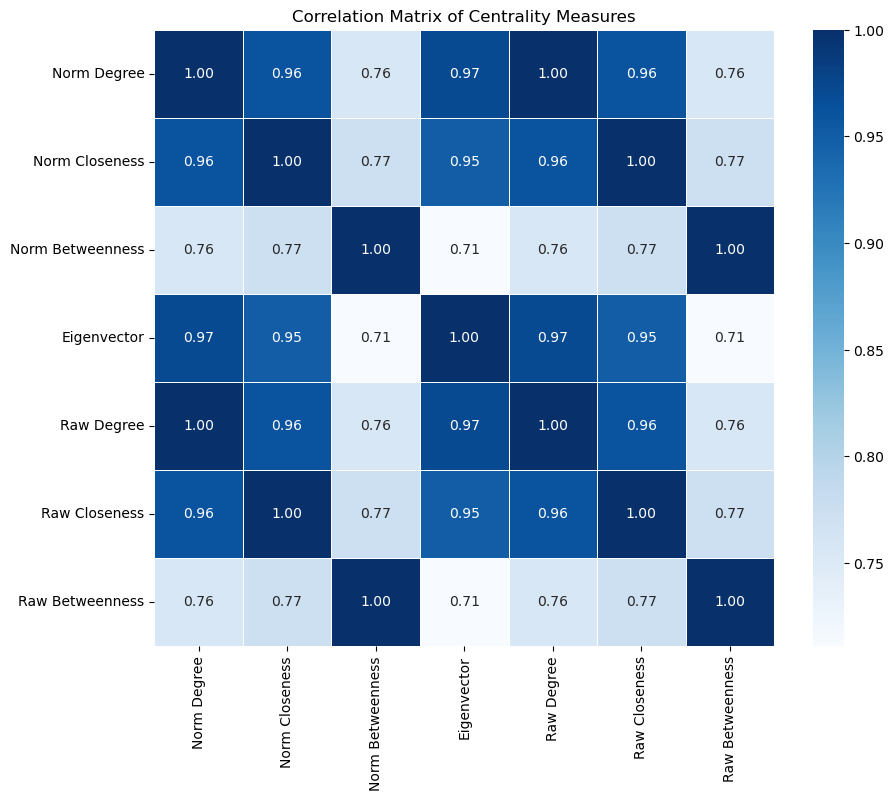

In [12]:
# Compute correlation matrix
centrality_correlation_matrix = centrality_df.corr()

# Display the correlation matrix
print("\n=== Correlation Matrix of Centrality Measures ===")
print(centrality_correlation_matrix)

# Visualize it in a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(centrality_correlation_matrix, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Centrality Measures")
plt.show()

**Interpretation of correlation matrix**

- By construction, the correlation of each centrality measure with itself, and the correlation between each centrality measure's raw and normalized form, equals 1. They are perfectly correlated as they equal, or can be easily derived from, each other.

- All measures of centrality are at least moderately positively correlated with each other (r > 0.7 for all pairs).This makes sense, as we expect countries that are in PTAs with more countries (high degree centrality) to have shorter paths connecting them and any other country (high closeness centrality), to be connected to more well-connected countries (high eigenvector centrality), and to fall between more geodesic paths between other countries (high betweeness centrality).

- Among these measures, degree, closeness, and eigenvector centrality are especially highly correlated, with correlations of 0.95 to 0.97 between their pairs. 

- Betweenness centrality has the weakest positive correlation with the other centrality measures, ranging from 0.71 to 0.76. 
    - In our context, betweeness centrality captures a country's structural influence as a trade hub, indicating how often it other nations' geodesic paths pass through it, and thus how often it likely serves as an intermediary in trade routes between other nations.
    - This suggests that intermediary countries that facilitate trade between others do not always overlap perfectly with the most connected (high degree and closeness centrality) economies. 
    - This distinction highlights the unique role of transit hubs, which may not necessarily be dominant trading powers but are strategically positioned within the global trade network.

#### 2c- Highlight which nodes are most central and least central, along different dimensions.

Let's first merge the attribute data to our centrality data frame:

In [13]:
# Set 'Country Code' as the index for df_attr
df_attr.set_index("Country Code", inplace=True)

# Merge the dataframes, keeping all entries from centrality_df
merged_df = centrality_df.join(df_attr, how="left")

Now, look at the countries with highest and lowest *degree centrality* and their attributes.

In [14]:
# Sort by Norm Degree to find most and least central countries
df_sorted_degree = merged_df.sort_values(by="Norm Degree", ascending=False)
top_5_central_degree = df_sorted_degree.head(5)
bottom_5_central_degree = df_sorted_degree.tail(5)

# Display results
print("\n=== Top 5 Most Central Countries (by degree centrality) ===")
print(top_5_central_degree)
print("\n=== Bottom 5 Least Central Countries (by degree centrality) ===")
print(bottom_5_central_degree)


=== Top 5 Most Central Countries (by degree centrality) ===
     Norm Degree  Norm Closeness  Norm Betweenness  Eigenvector  Raw Degree  \
EGY     0.609524        0.684039          0.030204     0.123517       128.0   
TUN     0.604762        0.681818          0.028167     0.123343       127.0   
MAR     0.585714        0.673077          0.025635     0.121039       123.0   
MLT     0.542857        0.675241          0.011605     0.121825       114.0   
EST     0.542857        0.675241          0.011605     0.121825       114.0   

     Raw Closeness  Raw Betweenness           Country  \
EGY       0.003257       662.834821  Egypt, Arab Rep.   
TUN       0.003247       618.135438           Tunisia   
MAR       0.003205       562.551458           Morocco   
MLT       0.003215       254.675459             Malta   
EST       0.003215       254.675459           Estonia   

     Exports of G&S (% of GDP)  FDI, net inflows (% of GDP)  \
EGY                  19.102104                     2.48498

**Interpetation of results**

- The top 5 countries and territories with the most trade connections with other countries via preferential trade agreements are Egypt, Tunisia, Morocco, Malta, and Estonia. The bottom 5 countries and territories with the least such connections are Taiwan, Azerbaijan, Turkmenistan, Macao, and Mongolia.

- Unfortunately, unlike our intial hypothesis, we do not observe that the top 5 countries have especially higher export/ import/ FDI/ merchandise trade levels as a percentage of GDP relative to the bottom 5 countries. 
    - In fact, Egypt, which has the highest degree centrality, has lower than median levels of exports (19% vs median 39%), imports (21% vs median 44%), and merchandise trade (32% vs median 57%).
    - The other top 4 countries have higher than median levels of exports, imports, and merchandise trade. But Mongolia, the lowest degree centrality country, also has higher than median levels of exports, imports, and merchandise trade.

- This suggests that the level of trade and FDI a country has may not be the main determinants of whether countries enter into many trade agreements. 

- For example, we notice that Taiwan and Macao are in the bottom 5. This makes sense since Taiwan's complex geopolitical status may limit the willingness of other countries to enter into formal trade agreements with it, and Macao is a territory rather than a country, so it will naturally have much more limited direct trade agreements.

- Moreover, it is possible that countries with high levels of trade may only trade with a handful of countries, and thus only need agreeements with a small number of countries. Then, degree centrality may be associated with the diversity of trade partners, which may not necessarily be correlated with the level of trade.

Now, look at the countries with highest and lowest *betweeness centrality* and their attributes.

In [15]:
# Sort by Norm Betweenness to find most and least central countries
df_sorted_betweeness = merged_df.sort_values(by="Norm Betweenness", ascending=False)
top_5_central_betweeness = df_sorted_betweeness.head(5)
bottom_5_central_betweeness = df_sorted_betweeness.tail(5)

# Display results
print("\n=== Top 5 Most Central Countries (by betweeness centrality) ===")
print(top_5_central_betweeness)
print("\n=== Bottom 5 Least Central Countries (by betweeness centrality) ===")
print(bottom_5_central_betweeness)


=== Top 5 Most Central Countries (by betweeness centrality) ===
     Norm Degree  Norm Closeness  Norm Betweenness  Eigenvector  Raw Degree  \
EGY     0.609524        0.684039          0.030204     0.123517       128.0   
TUN     0.604762        0.681818          0.028167     0.123343       127.0   
MAR     0.585714        0.673077          0.025635     0.121039       123.0   
VNM     0.395238        0.623145          0.025115     0.087626        83.0   
SGP     0.447619        0.636364          0.022732     0.095910        94.0   

     Raw Closeness  Raw Betweenness           Country  \
EGY       0.003257       662.834821  Egypt, Arab Rep.   
TUN       0.003247       618.135438           Tunisia   
MAR       0.003205       562.551458           Morocco   
VNM       0.002967       551.145236          Viet Nam   
SGP       0.003030       498.847273         Singapore   

     Exports of G&S (% of GDP)  FDI, net inflows (% of GDP)  \
EGY                  19.102104                     2.4

**Interpretation of results**

- The top 5 countries and territories with the highest betweeness centrality are Egypt, Tunisia, Morocco, Vietnam, and Singapore. The bottom 5 countries and territories with the lowest betweeness centrality are Somalia, Saint Pierre and Miquelon, Congo, South Sudan, and Aruba.

- Again, unlike our intial hypothesis, we do not clearly observe that the top 5 countries have especially higher export/ import/ FDI/ merchandise trade levels as a percentage of GDP relative to the bottom 5 countries. 
    - Among the top 5 countries, Singapore and Vietnam have high levels of exports, imports, merchandise trade, and FDI, as a percentage of GDP. Their values exeed the 75 percentile of all countries and territories (75th percentile is: 56% exports, 64% imports, 83% merchandise trade, 4% FDI). Tunisia and Morocco have above median values for exports, imports, and merchandise trade as well, but not for FDI. 
    - However, Egypt has below median values for all attributes.
    - Among the bottom 5 countries, Aruba has above median exports (88%) and imports (81%), and Congo has above median exports (57%) and merchandise trade (86%).

- Since Saint Pierre and Miquelon is a french territory rather than an independent nation and Aruba's foreign relations is covered by the Dutch government, it is unsuprising that they would have limited trade agreements and have low betweeness centrality.

### 3- If you have a network with attribute data, then state some hypothesis about how an attribute may be related to some (or all of the) measures of centrality.  Explains why you think these two variables should be related.

We hypothesized that countries with high centrality measures tend to have high exports, imports, merchandise trade, and FDI, as a percentage of GDP.

- Countries which depend more heavily on trade, as reflected by higher exports/ imports/ merchandise trade as a percentage of GDP, have greater incentives to enter into preferential trade agreements with other countries, raising degree centrality. Higher degree centrality tends to also result in higher closeness and eigenvector centrality (e.g. when you establish agreements with well-connected countries).

- Countries with high degree, closeness, and eigenvector centrality are also more well-connected to other countries and well-connected countries, so they can trade with any other country more easily. This may facilitate further trade and increase these metrics. 

- As such agreements also often include provisions to facilitate foreign investment, beyond preferential tariffs, we expect countries with high degree centrality (more agreemenst with other countries) to have higher foreign direct investment levels.

Our initial observations from looking at the attributes of the top and bottom 5 degree centrality countries and territories are not promising in terms of support to the hypothesis. Nevertheless, let's look at this a bit more formally by considering correlations across our data set.

In [16]:
# Select only numeric columns for correlation calculation
numeric_df = merged_df.select_dtypes(include=[np.number])

# Compute correlation with selected trade-related attributes
corr_degree = numeric_df[["Exports of G&S (% of GDP)", 
                          "Imports of G&S (% of GDP)",
                          "Merchandise trade (% of GDP)", 
                          "FDI, net inflows (% of GDP)"]].corrwith(numeric_df["Norm Degree"])

corr_closeness = numeric_df[["Exports of G&S (% of GDP)",
                             "Imports of G&S (% of GDP)",
                             "Merchandise trade (% of GDP)", 
                             "FDI, net inflows (% of GDP)"]].corrwith(numeric_df["Norm Closeness"])

corr_eigenvector = numeric_df[["Exports of G&S (% of GDP)",
                               "Imports of G&S (% of GDP)",
                               "Merchandise trade (% of GDP)", 
                               "FDI, net inflows (% of GDP)"]].corrwith(numeric_df["Eigenvector"])

corr_betweeness = numeric_df[["Exports of G&S (% of GDP)",
                              "Imports of G&S (% of GDP)",
                              "Merchandise trade (% of GDP)", 
                              "FDI, net inflows (% of GDP)"]].corrwith(numeric_df["Norm Betweenness"])

# Display results
print("\n=== Correlation Between Attributes and Degree Centrality ===")
print(corr_degree)
print("\n=== Correlation Between Attributes and Closeness Centrality ===")
print(corr_closeness)
print("\n=== Correlation Between Attributes and Eigenvector Centrality ===")
print(corr_eigenvector)
print("\n=== Correlation Between Attributes and Betweenness Centrality ===")
print(corr_betweeness)


=== Correlation Between Attributes and Degree Centrality ===
Exports of G&S (% of GDP)       0.214733
Imports of G&S (% of GDP)       0.095824
Merchandise trade (% of GDP)    0.151814
FDI, net inflows (% of GDP)    -0.099011
dtype: float64

=== Correlation Between Attributes and Closeness Centrality ===
Exports of G&S (% of GDP)       0.244194
Imports of G&S (% of GDP)       0.097280
Merchandise trade (% of GDP)    0.189739
FDI, net inflows (% of GDP)    -0.102037
dtype: float64

=== Correlation Between Attributes and Eigenvector Centrality ===
Exports of G&S (% of GDP)       0.229576
Imports of G&S (% of GDP)       0.112713
Merchandise trade (% of GDP)    0.150468
FDI, net inflows (% of GDP)    -0.067843
dtype: float64

=== Correlation Between Attributes and Betweenness Centrality ===
Exports of G&S (% of GDP)       0.185886
Imports of G&S (% of GDP)       0.088060
Merchandise trade (% of GDP)    0.170530
FDI, net inflows (% of GDP)    -0.079365
dtype: float64


**Interpretation of results**

- In line with our hypothesis, we observe positive correlations between exports, imports, merchandise trade, and centrality measures. 
    - Note that this may not be statistically significant, particularly given the small positive correlation value for imports (r between 0.09 to 0.11). 
    - Nevertheless, the direction of the correlation aligns with our expectations.

- Maybe our hypothesis is right: countries with high levels of trade (particularly exports and merchandise trade as shown by higher correlation values), are incetivized to enter trade agreements, raising centrality measures. 

- Since imports is rather weakly correlated relative to exports, this suggests that countries with high export levels may enter trade agreements, which could benefit their export businesses. However, this is less of the case for countries with high import levels. 
    - Perhaps, there is a smaller incentive to reduce trade barriers to import more. While it may lower price levels in a country as cheaper foreign goods and services are imported, this may be a weaker motivator as it also necessarily raises domestic competition for local firms targeting the local market, which is not politically popular. 
    - Note however that this is all speculation, and we cannot make clear conclusions from running simple correlations.

- However, we observe negative correlation with FDI which is against our hypothesis, though the correlation is again small (r between -0.07 and -0.10). Maybe other factors such as the availability and quality of investment opportunities are the key drivers of FDI. Agreements may reduce the friction of foreign investment, but this is not the main factor driving FDI decisions and levels.

### 4- In either case, when you are done above, then considers alternate specifications of your variables and codings and decisions and models.  What would you want to consider changing and why. If you can, report on what are the consequences of those changes?

We hypothesized that exports, imports, merchandise trade, and FDI levels are positively associated with degree centrality. In question (3), we studied it using simple correlations. Let's **consider an alternate specification in the form of an OLS regression model** and observe results.In our OLS regression, we use country attributes as independent variables and degree centrality as the dependent variable. 

**Consequences of this change**: This way, we get to see the associations net of each other. For example, we get to see if export levels (% of GDP) is associated with degree centrality, net of imports, FDI, and merchandise trade. We also get to conduct two-tailed z-tests on the coefficients to test for significance, an improvement from our simple correlation analysis in question (3).

Before we do so, let's check the variance inflation factor (VIF) of each independent variable to detect potential multicollinearity issues with such a OLS regression. Intuitively, exports, imports, and merchandise trade levels are positively correlated, and we do not want them to be correlated to the extent that multicollinearity issues arise, preventing reasonable estimation of coefficients.

In [17]:

# Define independent variables for VIF calculation
X_vif = numeric_df[["Exports of G&S (% of GDP)", "Imports of G&S (% of GDP)", 
                    "Merchandise trade (% of GDP)", "FDI, net inflows (% of GDP)"]].dropna()

# Add constant for VIF calculation
X_vif = sm.add_constant(X_vif)

# Compute VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Display VIF values
print("\n=== Variance Inflation Factor (VIF) ===")
print(vif_data)



=== Variance Inflation Factor (VIF) ===
                        Feature       VIF
0                         const  4.123038
1     Exports of G&S (% of GDP)  4.408612
2     Imports of G&S (% of GDP)  5.226530
3  Merchandise trade (% of GDP)  2.287683
4   FDI, net inflows (% of GDP)  1.020449


Since the VIF values are all less than 10, there is no multicollinearity issue with our OLS model. Let us go ahead and fit the OLS model:

In [18]:
# Define independent variables
X = numeric_df[["Exports of G&S (% of GDP)", "Imports of G&S (% of GDP)", 
                "Merchandise trade (% of GDP)", "FDI, net inflows (% of GDP)"]].dropna()

# Define dependent variable (degree centrality)
y = numeric_df.loc[X.index, "Raw Degree"]  # Ensure matching indices

# Add a constant to the independent variables
X = sm.add_constant(X)

# Run regression model
model = sm.OLS(y, X).fit()

# Display regression results
print("\n=== Regression Results: Raw Degree Centrality on Country Attributes ===")
print(model.summary())


=== Regression Results: Raw Degree Centrality on Country Attributes ===
                            OLS Regression Results                            
Dep. Variable:             Raw Degree   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     2.151
Date:                Mon, 31 Mar 2025   Prob (F-statistic):             0.0775
Time:                        17:07:47   Log-Likelihood:                -731.23
No. Observations:                 148   AIC:                             1472.
Df Residuals:                     143   BIC:                             1487.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

**Interpretation of results**
- The regression suggests that country trade and FDI attributes do not strongly predict degree centrality. The model explains only 5.7% of the variation in raw degree centrality (R² = 0.057), and the F-statistic (p = 0.0775) indicates that the overall model is not statistically significant (p > 0.05).

- The low R² implies that factors outside of trade and FDI levels, are likely more critical to degree centrality in trade networks. Examples of such factors could include:
    - The diversity of trade partners: countries which have a handful of main and reliable trading partners may have less incentives to sign agreements with countries beyond those 5, given small trade volumes with other countries.
    - Geopolitical issues: western countries erecting trade barriers with Russia after the Ukraine war, difficulty of Taiwan to sign formal trade agreements given the "One China" policy, recent US-China trade tensions etc.
    - Geography: e.g. a land-locked country may not enter into direct trade agreements with far-away countries as it is hard to trade without sea ports even if an agreement is signed. Instead, trading is mostly done through neighboring countries.

- Exports of goods and services (% of GDP) is positively associated with degree centrality, net of other factors, as expected. This association is statistically significant (p < 0.05). A 1% increase in a country's exports of goods and services as a percentage of GDP is associated with a 0.3653 increase in raw degree centrality.

- Imports of goods and services, merchandise trade, and FDI are all not significantly related to degree centrality (p > 0.1). The coefficient on merchandise trade is positive, in line with our hypothesis. However, the coefficients on FDI and imports are negative, against our hypothesis.
    - A possible explanation for a negative coefficient on imports, net of other factors, is that countries with high levels of imports may be pressured to protect their domestic industries from competitive imports that outcompete local firms. As such, they may be less willing to enter into trade agreements.
    - Perhaps the positive correlation of imports and degree centrality observed in question 3 arises due to imports and exports being positively correlated. Once we control for exports, the association of imports and degree centrality then turns negative.



### 5- Lastly, give your best conclusion as to what you learned from your analysis.  Did it make sense, given your initial expectations? Why? Why not?

Exports of goods and services (as a % of GDP) is positively and significantly associated with the number of other countries a country has preferntial trade agreements with. This was in line with my initial expectations. This makes sense as export-dependent countries have greater incentives to lower trade barriers with others, and lowered trade barriers further increases exports.

However, against my initial expectations, imports, merchandise trade, and FDI levels seem to have no significant association with the number of other countries a country has trade agreements with, net of each other and exports.

Overall, it appears that there are many other drivers behind when countries enter into trade agreements, which are unrelated to levels of exports, imports, merchandise trade, and FDI. We have suggested that some of these factors could be geopolitical issues and geography, which may be harder to quantify.

### Extra visualization

Just for fun, I have visualized the trade network below. The nodes are labelled with their 3-letter ISO country codes. The node size reflects the normalized degree centrality, and the node colors represent exports of goods and services as a percentage of GDP.

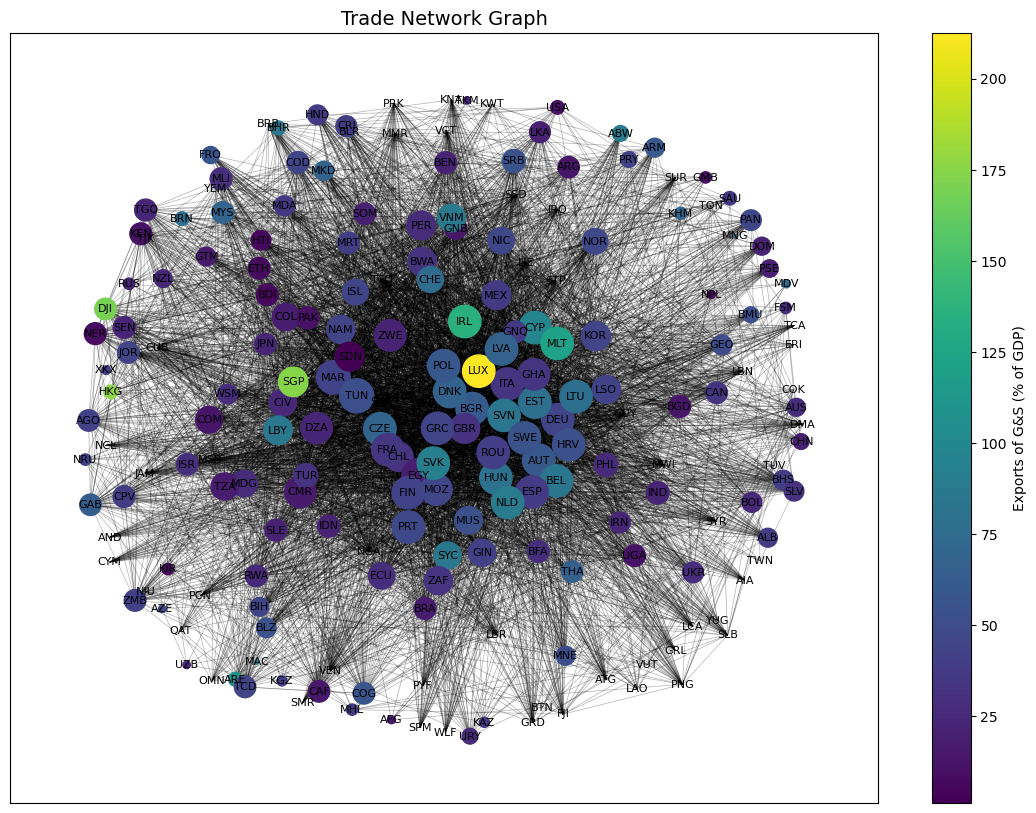

In [19]:
# Node attributes from merged_df
node_sizes = merged_df["Norm Degree"] * 1000  # Scale up for visibility
node_colors = merged_df["Exports of G&S (% of GDP)"]

# Normalize colors
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=node_colors.min(), vmax=node_colors.max())
normalized_colors = cmap(norm(node_colors))

# Adjust node repulsion by changing k in spring_layout
pos = nx.spring_layout(G, k=2, iterations=50)  # Increase k for more space, iterations for stability

# Create figure
fig, ax = plt.subplots(figsize=(14, 10))

# Draw network
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=normalized_colors, ax=ax)
nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5, ax=ax)
nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Exports of G&S (% of GDP)")

plt.title("Trade Network Graph", fontsize=14)
plt.show()

**Interpretation**
- In general, countries with high degree centrality (larger nodes), tend to have higher exports as a percentage of GDP (lighter colors). 
    - In the graph above, these countries are found mostly in the middle, with periphery countries generally having smaller, darker nodes.
    - This is not always the case. Notably, Hong Kong (HKG) has a rather low degree centrality (small node size), but high exports as a percentage of GDP (light color). 

- Visually, Luxemberg (LUX), in the middle of the graph, has particularly high exports (as % of GDP) and also has high degree centrality.